In [12]:
import pyvisa as visa
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time
from tqdm import tqdm
import datetime
import pickle

sns.set(font_scale=1.2, style='whitegrid')
%matplotlib inline

# Connect devices

In [13]:
SPEC_ANALYZER_NAME = 'GPIB0::18::INSTR'
SIG_GEN_NAME = 'USB0::0xF4EC::0x1103::SDG1XDDX6R5043::INSTR'

rm = visa.ResourceManager()
assert SIG_GEN_NAME in rm.list_resources()
assert SPEC_ANALYZER_NAME in rm.list_resources()

spec = rm.open_resource(SPEC_ANALYZER_NAME)
sig = rm.open_resource(SIG_GEN_NAME)

# Data Taking Routines

In [14]:
def set_central_freq(f):
    spec.write(f'SENS:FREQ:CENTER {f}')

def set_span_freq(deltaf):
    spec.write(f'SENS:FREQ:SPAN {deltaf}')
    
def set_res_bandwidth(f):
    spec.write(f'SENS:BAND {f}')

def set_sweep_time(tsweep):
    spec.write(f'SENS:SWE:TIME {tsweep}')

def get_trace():
    dat = spec.query('TRACE:DATA? Trace1')
    trace = np.array([float(x) for x in dat.split(',')])
    return trace

def get_fake_trace(num=401):
    return np.random.randn(num) - 95

def reset_avg_trace(count):
    spec.write('SENS:AVERage OFF')
    spec.write('SENS:AVERage ON')
    spec.write(f'SENS:AVERage:COUNt {count}')
    
def set_frequency(f):
    sig.write(f'C1:BSWV FRQ, {f}')
    
def set_delay(delta_t):
    sig.write(f'C2:BSWV DLY, {delta_t}')
    
def set_pulse_length(tau):
    sig.write(f'C1:BTWV TIME, {tau}')

In [15]:
def save_data(data, fname):
    with open(f'{fname}.pickle', 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

def load_data(fname):
    with open(f'{fname}.pickle', 'rb') as handle:
        return pickle.load(handle)

# Sweepers and plotters

In [16]:
def perform_frequency_sweep(save_name):
    frequencies = np.array(list(range(parameters['fstart'], parameters['fend'], parameters['fdelta'])))
    wait_time = parameters['numAvrg'] * parameters['dutyCycleTime'] + parameters['epsTime']
    total_time = len(frequencies) * wait_time
    display_time = str(datetime.timedelta(seconds=total_time))
    print(f"Total wait time {display_time}")

    # reset the trace
    set_central_freq(parameters['fcenterDisplay'])
    set_span_freq(parameters['fspanDisplay'])
    reset_avg_trace(parameters['numAvrg'])
    set_sweep_time(parameters['sweepTime'])
    set_res_bandwidth(parameters['resBandwidth'])

    # run data acquistion
    traces = []
    max_power = []
    best_trace = []
    best_freq, best_power = None, -np.inf
    pbar = tqdm(frequencies)
    for freq in pbar:
        
        # fix frequency
        set_frequency(freq)
        if parameters['fspanDisplay'] == 0:
            set_central_freq(freq)
        time.sleep(wait_time)
        reset_avg_trace(parameters['numAvrg'])
        trace = get_trace()
        power = trace.max()
        traces.append(trace)
        max_power.append(power)
        
        # keep track of best traces
        if power > best_power:
            best_freq = freq
            best_trace = trace
            best_power = power

        # update progress
        pbar.set_description(f"Freq: {freq} Hz, Signal: {power:.3f} dB, Max Signal: {best_power:.3f} dB @ Freq {best_freq} Hz")
        
    # convert to np arrays
    traces = np.array(traces)
    max_power = np.array(max_power)
    
    # save data
    sweep_data = {
        'all_traces': traces,
        'power(freq)': max_power,
        'frequencies': frequencies,
        'best_trace': best_trace,
        'best_freq': best_freq,
        'best_power': best_power,
        'parameters': parameters
    }
    save_data(sweep_data, save_name)
    return sweep_data

In [17]:
def visualize_sweep(sweep_data):
    parameters = sweep_data['parameters']
    best_power = sweep_data['best_power']
    best_freq = sweep_data['best_freq']
    best_trace = sweep_data['best_trace']
    print(f"Max signal of {best_power} dBm was obtained @ {best_freq} Hz")
    trace_lower = parameters['fcenterDisplay'] - parameters['fspanDisplay']/2
    trace_upper = parameters['fcenterDisplay'] + parameters['fspanDisplay']/2
    if parameters['fspanDisplay'] == 0:
        trace_lower = 0
        trace_upper = parameters['sweepTime']
    trace_points = np.linspace(trace_lower, trace_upper, len(best_trace))
    if  parameters['fspanDisplay'] == 0:
        print(f"Our best trace has a peak @ {trace_points[np.argmax(best_trace)]} s:")
    else:
        print(f"Our best trace has a peak @ {trace_points[np.argmax(best_trace)]} Hz:")
    plt.figure(figsize=(10, 6))
    plt.plot(trace_points, best_trace)
    if  parameters['fspanDisplay'] == 0:
        plt.xlabel('Sweep Time [s]')
    else:
        plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power [dBm]')
    plt.show()
    
    print('Plotting peak as a function of frequencies')
    plt.figure(figsize=(10, 6))
    plt.plot(sweep_data['frequencies'], sweep_data['power(freq)'])
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Power [dBm]')
    plt.show()

In [18]:
def run_time_estimate(parameters):
    frequencies = np.array(list(range(parameters['fstart'], parameters['fend'], parameters['fdelta'])))
    wait_time = parameters['numAvrg'] * parameters['dutyCycleTime'] + parameters['epsTime']
    total_time = len(frequencies) * wait_time
    display_time = str(datetime.timedelta(seconds=total_time))
    print(f"Total wait time {display_time}")

# Experiments

Max signal of -85.493 dBm was obtained @ 3608300 Hz
Our best trace has a peak @ 0.0018800000000000002 s:


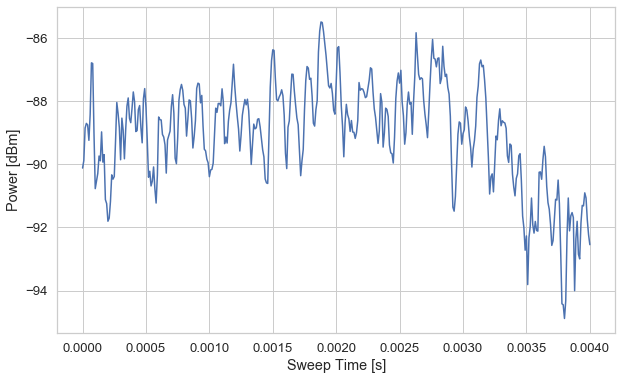

Plotting peak as a function of frequencies


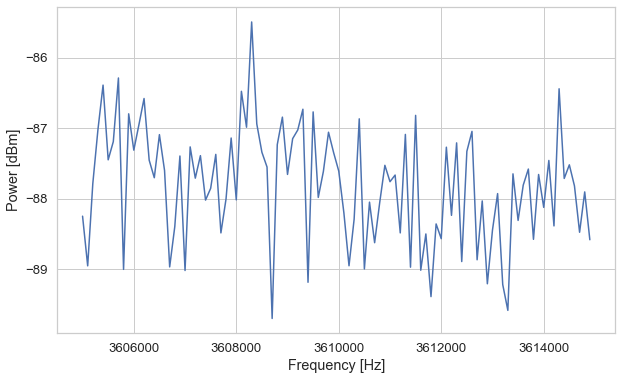

In [8]:
EXP_NAME = 'test_trinity'
parameters = {
    'fstart': 3605000,
    'fend': 3615000,
    'fdelta': 100,
    'dutyCycleTime': 1,
    'epsTime': 1e-6,
    'numAvrg': 10,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

#_ = perform_frequency_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

Max signal of -85.896 dBm was obtained @ 3607750 Hz
Our best trace has a peak @ 0.0022800000000000003 s:


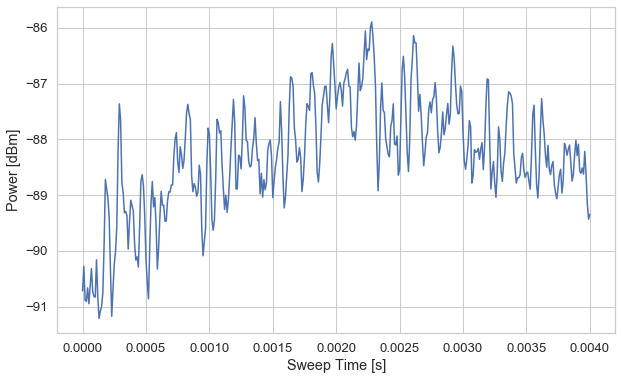

Plotting peak as a function of frequencies


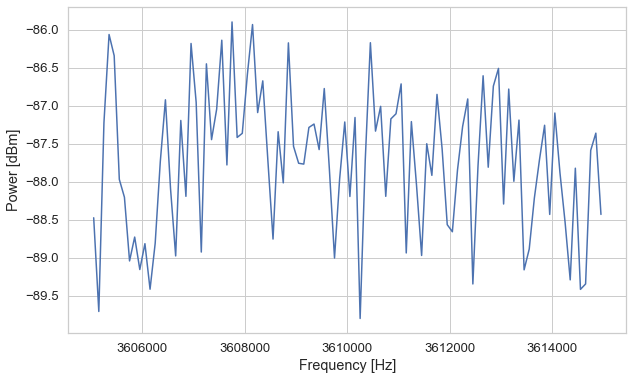

In [9]:
EXP_NAME = 'test_trinity_2'
parameters = {
    'fstart': 3605050,
    'fend': 3615050,
    'fdelta': 100,
    'dutyCycleTime': 0.5,
    'epsTime': 1e-7,
    'numAvrg': 20,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

#_ = perform_frequency_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

Total wait time 0:10:00.000004
Max signal of -87.023 dBm was obtained @ 3608650 Hz
Our best trace has a peak @ 0.00128 s:


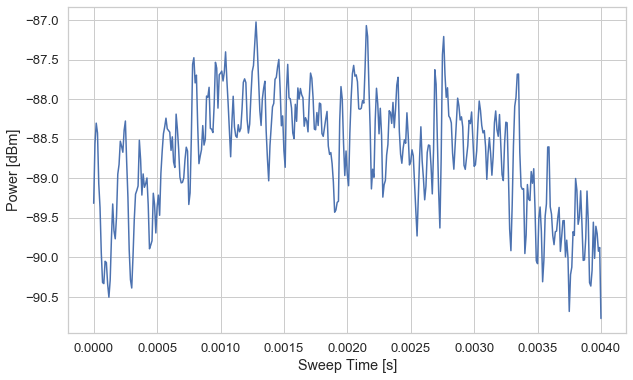

Plotting peak as a function of frequencies


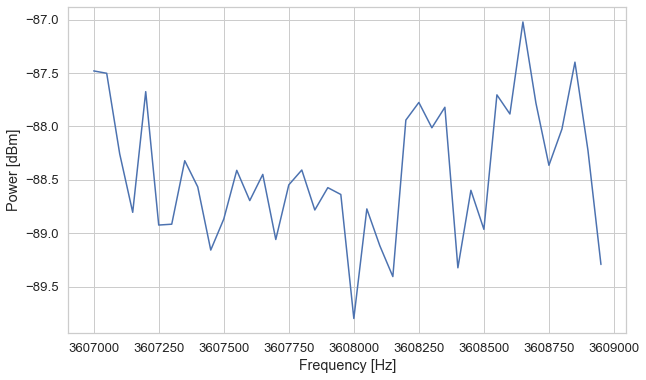

In [10]:
EXP_NAME = 'test_trinity_3'
parameters = {
    'fstart': 3607000,
    'fend': 3609000,
    'fdelta': 50,
    'dutyCycleTime': 0.5,
    'epsTime': 1e-7,
    'numAvrg': 30,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

run_time_estimate(parameters)
#_ = perform_frequency_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

Total wait time 0:07:30.000003
Total wait time 0:07:30.000003


Freq: 3609400 Hz, Signal: -91.511 dB, Max Signal: -90.646 dB @ Freq 3607600 Hz: 100%|██| 30/30 [07:33<00:00, 15.13s/it]


Max signal of -90.646 dBm was obtained @ 3607600 Hz
Our best trace has a peak @ 0.0018100000000000002 s:


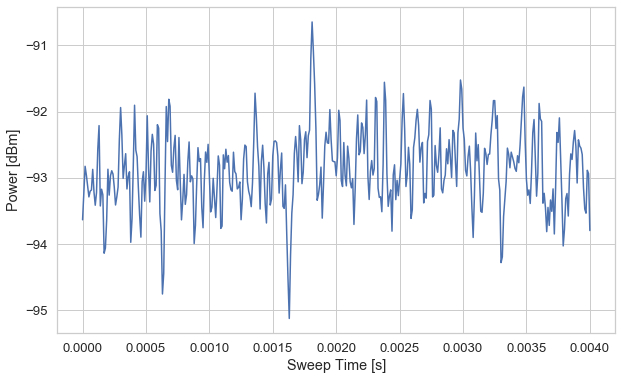

Plotting peak as a function of frequencies


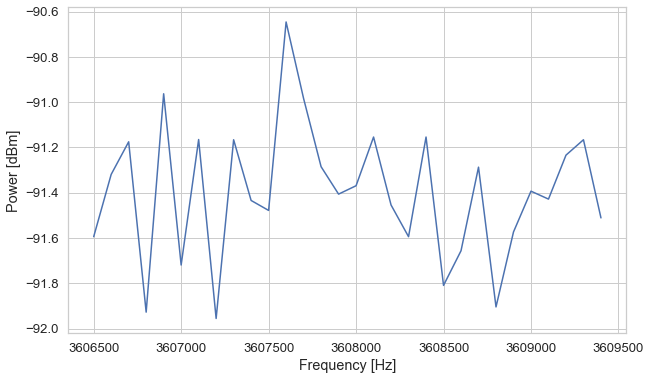

In [12]:
EXP_NAME = 'test_sukie_is_cool_but_Qfactor_is_bad'
parameters = {
    'fstart': 3606500,
    'fend': 3609500,
    'fdelta': 100,
    'dutyCycleTime': 0.5,
    'epsTime': 1e-7,
    'numAvrg': 30,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

run_time_estimate(parameters)
_ = perform_frequency_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

Total wait time 0:07:30.000003
Total wait time 0:07:30.000003


Freq: 3609350 Hz, Signal: -91.236 dB, Max Signal: -89.669 dB @ Freq 3608750 Hz: 100%|██| 30/30 [07:33<00:00, 15.12s/it]


Max signal of -89.669 dBm was obtained @ 3608750 Hz
Our best trace has a peak @ 0.0 s:


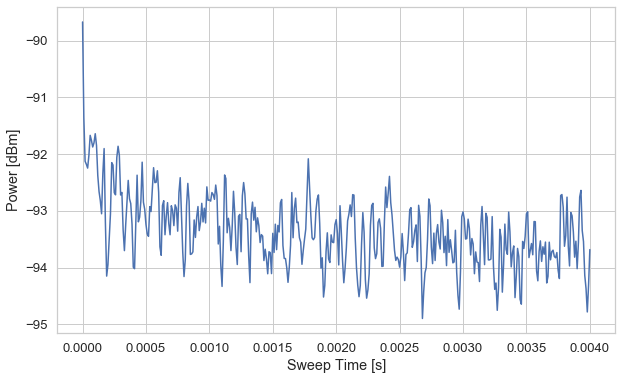

Plotting peak as a function of frequencies


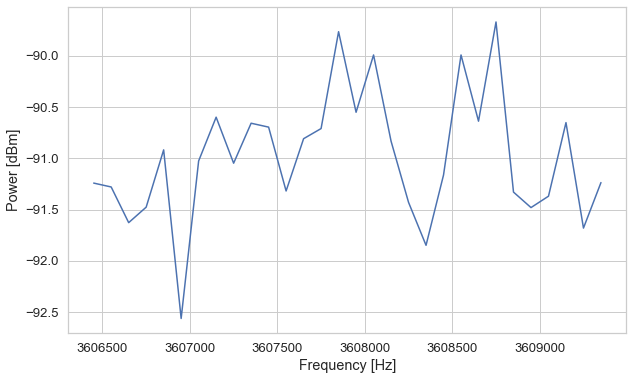

In [8]:
EXP_NAME = 'test_sukie_is_cool_but_Qfactor_is_bad_2'
parameters = {
    'fstart': 3606450,
    'fend': 3609450,
    'fdelta': 100,
    'dutyCycleTime': 0.5,
    'epsTime': 1e-7,
    'numAvrg': 30,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

run_time_estimate(parameters)
_ = perform_frequency_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

Total wait time 0:12:30.000005
Total wait time 0:12:30.000005


Freq: 3608950 Hz, Signal: -88.912 dB, Max Signal: -86.391 dB @ Freq 3608550 Hz: 100%|██| 50/50 [12:36<00:00, 15.14s/it]


Max signal of -86.391 dBm was obtained @ 3608550 Hz
Our best trace has a peak @ 0.0 s:


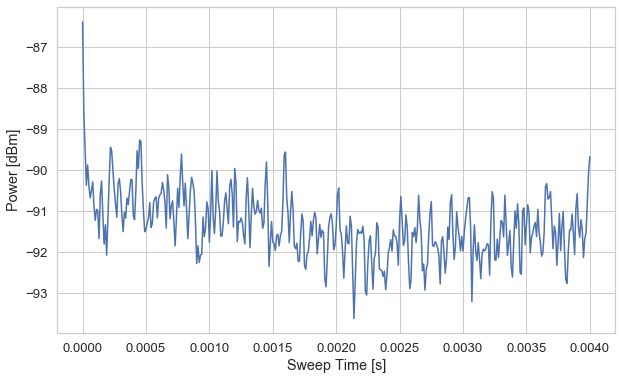

Plotting peak as a function of frequencies


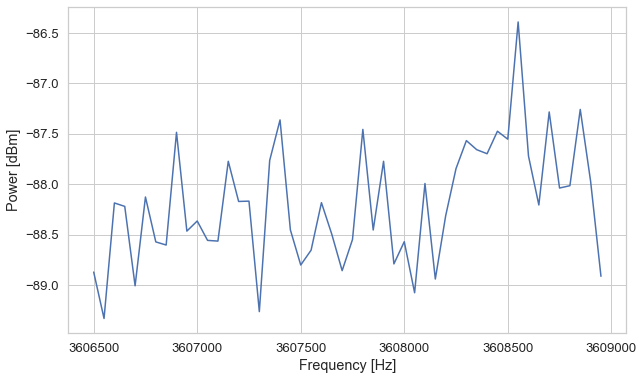

In [14]:
EXP_NAME = 'test_sukie_is_cool_but_Qfactor_is_bad_3'
parameters = {
    'fstart': 3606500,
    'fend': 3609000,
    'fdelta': 50,
    'dutyCycleTime': 0.5,
    'epsTime': 1e-7,
    'numAvrg': 30,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

run_time_estimate(parameters)
_ = perform_frequency_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

Total wait time 0:07:30.000006
Total wait time 0:07:30.000006


Freq: 3609450 Hz, Signal: -85.275 dB, Max Signal: -84.646 dB @ Freq 3607850 Hz: 100%|██| 60/60 [07:37<00:00,  7.63s/it]


Max signal of -84.646 dBm was obtained @ 3607850 Hz
Our best trace has a peak @ 0.0 s:


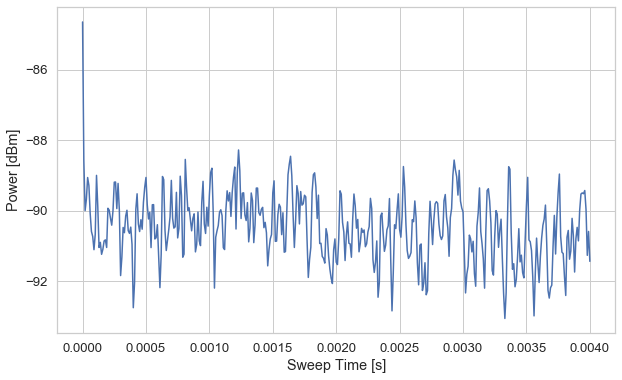

Plotting peak as a function of frequencies


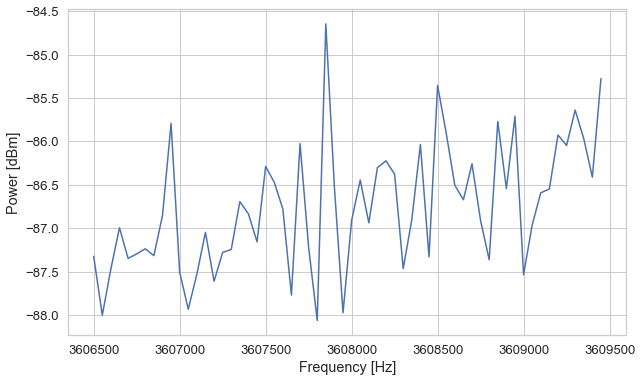

In [15]:
EXP_NAME = 'test_sukie_is_cool_but_Qfactor_is_bad_3'
parameters = {
    'fstart': 3606500,
    'fend': 3609500,
    'fdelta': 50,
    'dutyCycleTime': 0.5,
    'epsTime': 1e-7,
    'numAvrg': 30,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

run_time_estimate(parameters)
_ = perform_frequency_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

Total wait time 0:05:00.000004
Total wait time 0:05:00.000004


Freq: 3608475 Hz, Signal: -86.889 dB, Max Signal: -85.115 dB @ Freq 3608400 Hz: 100%|██| 40/40 [05:05<00:00,  7.63s/it]


Max signal of -85.115 dBm was obtained @ 3608400 Hz
Our best trace has a peak @ 0.0 s:


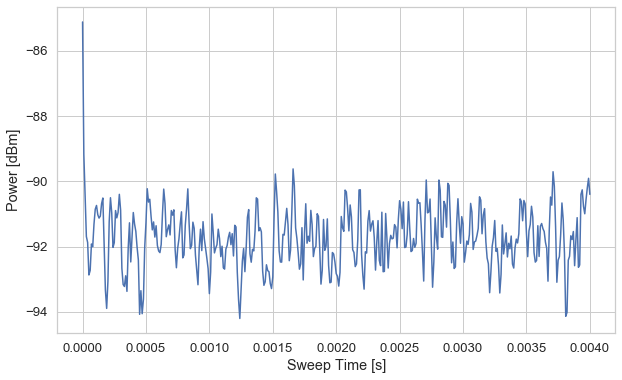

Plotting peak as a function of frequencies


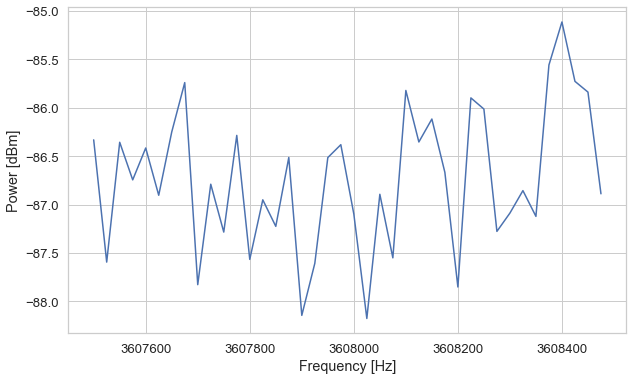

In [16]:
EXP_NAME = 'test_sukie_is_cool_but_Qfactor_is_bad_4'
parameters = {
    'fstart': 3607500,
    'fend': 3608500,
    'fdelta': 25,
    'dutyCycleTime': 0.5,
    'epsTime': 1e-7,
    'numAvrg': 30,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

run_time_estimate(parameters)
_ = perform_frequency_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

In [ ]:
EXP_NAME = 'test_sukie_is_cool_but_Qfactor_is_bad_delay'
parameters = {
    'fstart': 3607000,
    'fend': 3609000,
    'fdelta': 100,
    'dutyCycleTime': 0.25,
    'epsTime': 1e-7,
    'numAvrg': 30,
    'fcenterDisplay': 3610000,
    'fspanDisplay': 0,
    'resBandwidth': 30000,
    'sweepTime': 0.004
}

#run_time_estimate(parameters)
_ = perform_delay_sweep(EXP_NAME)
sweep_data = load_data(EXP_NAME)
visualize_sweep(sweep_data)

Total wait time 0:12:30.000010


NCycles 112 s ,Freq: 3608400 Hz, Signal: -88.609 dB, Max Signal: -77.994 dB @ Freq 3608000 Hz:  70%|▋| 14/20 [09:00<03:48, 38.05s/it]

running experiment for 112
Total wait time 0:05:00.000004
Total wait time 0:05:00.000004


Freq: 3608475 Hz, Signal: -88.656 dB, Max Signal: -87.429 dB @ Freq 3607650 Hz: 100%|██| 40/40 [05:05<00:00,  7.63s/it]


Max signal of -87.429 dBm was obtained @ 3607650 Hz
Our best trace has a peak @ 0.0014000000000000002 s:


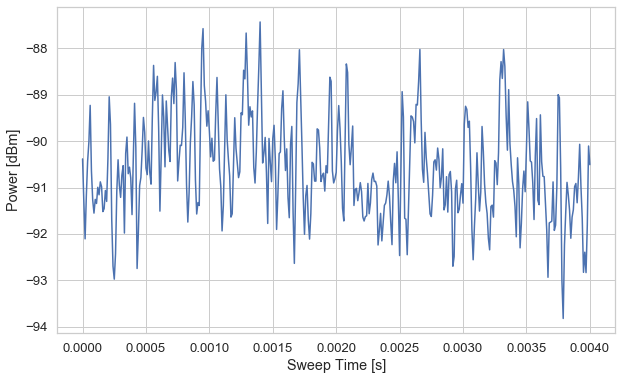

Plotting peak as a function of frequencies


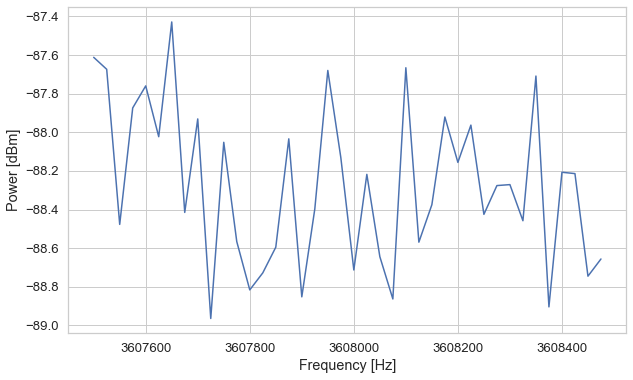

running experiment for 125
Total wait time 0:05:00.000004
Total wait time 0:05:00.000004


Freq: 3608475 Hz, Signal: -88.006 dB, Max Signal: -87.626 dB @ Freq 3608250 Hz: 100%|██| 40/40 [05:05<00:00,  7.63s/it]


Max signal of -87.626 dBm was obtained @ 3608250 Hz
Our best trace has a peak @ 0.00039000000000000005 s:


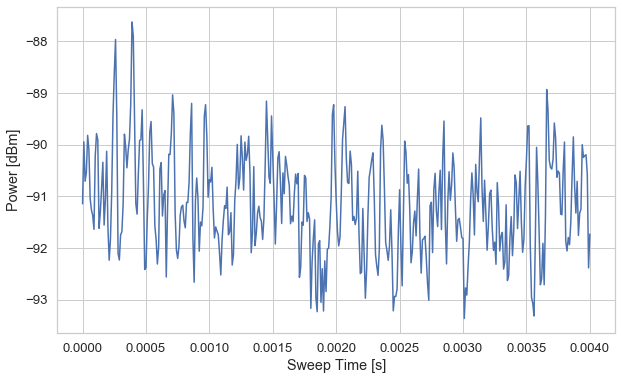

Plotting peak as a function of frequencies


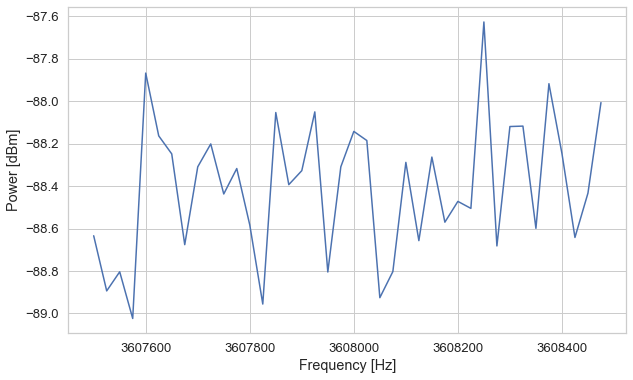

running experiment for 138
Total wait time 0:05:00.000004
Total wait time 0:05:00.000004


Freq: 3608475 Hz, Signal: -88.667 dB, Max Signal: -87.489 dB @ Freq 3608450 Hz: 100%|██| 40/40 [05:04<00:00,  7.62s/it]


Max signal of -87.489 dBm was obtained @ 3608450 Hz
Our best trace has a peak @ 0.00067 s:


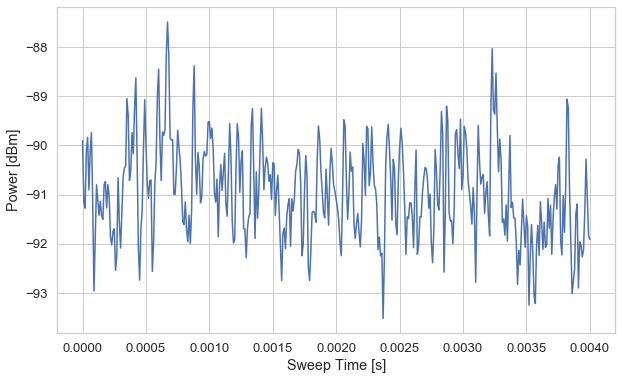

Plotting peak as a function of frequencies


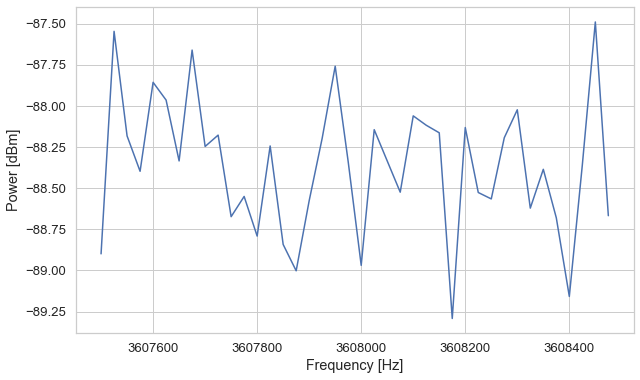

running experiment for 151
Total wait time 0:05:00.000004
Total wait time 0:05:00.000004


Freq: 3608475 Hz, Signal: -87.873 dB, Max Signal: -87.384 dB @ Freq 3607725 Hz: 100%|██| 40/40 [05:04<00:00,  7.62s/it]


Max signal of -87.384 dBm was obtained @ 3607725 Hz
Our best trace has a peak @ 0.0019600000000000004 s:


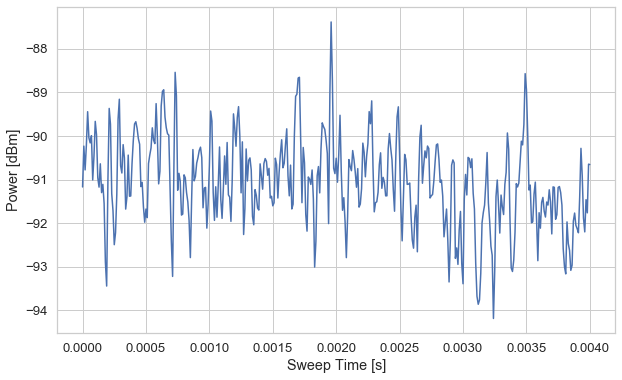

Plotting peak as a function of frequencies


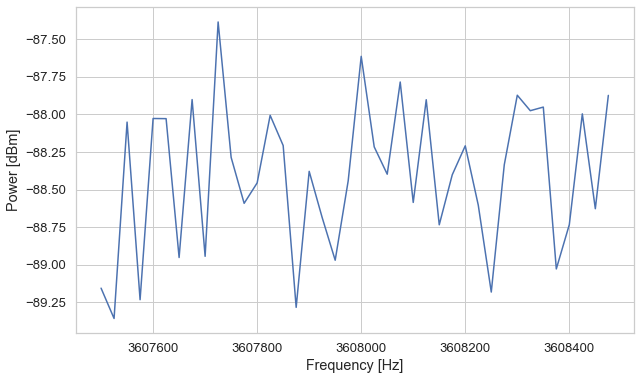

running experiment for 164
Total wait time 0:05:00.000004
Total wait time 0:05:00.000004


Freq: 3608475 Hz, Signal: -89.064 dB, Max Signal: -87.214 dB @ Freq 3607925 Hz: 100%|██| 40/40 [05:05<00:00,  7.63s/it]


Max signal of -87.214 dBm was obtained @ 3607925 Hz
Our best trace has a peak @ 0.0021200000000000004 s:


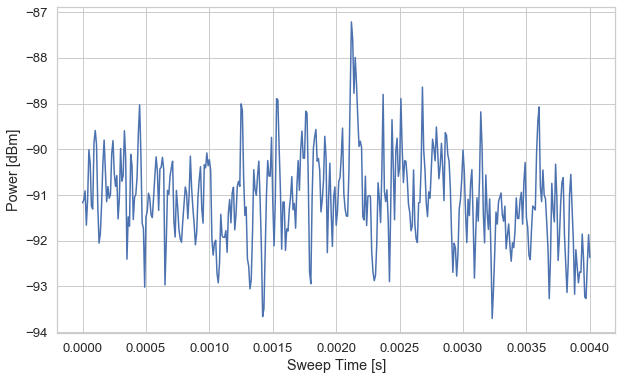

Plotting peak as a function of frequencies


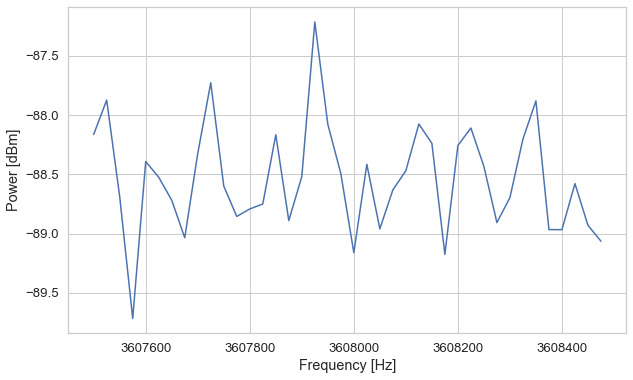

In [8]:
for numcycles in [112, 125, 138, 151, 164]:

    EXP_NAME = f'test_NCycles_{numcycles}'
    sig.write(f'C2:BSWV DLY, 180e-6')
    sig.write(f'C1:BTWV TIME, {numcycles}')
    parameters = {
        'fstart': 3607500,
        'fend': 3608500,
        'fdelta': 25,
        'dutyCycleTime': 0.5,
        'epsTime': 1e-7,
        'numAvrg': 30,
        'fcenterDisplay': 3610000,
        'fspanDisplay': 0,
        'resBandwidth': 30000,
        'sweepTime': 0.004
    }
    
    print(f'running experiment for {numcycles}')
    run_time_estimate(parameters)
    _ = perform_frequency_sweep(EXP_NAME)
    sweep_data = load_data(EXP_NAME)
    visualize_sweep(sweep_data)
    

running experiment for 112
Total wait time 0:10:00.000008
Total wait time 0:10:00.000008


Freq: 3608950 Hz, Signal: -88.076 dB, Max Signal: -86.989 dB @ Freq 3606950 Hz: 100%|██| 80/80 [10:10<00:00,  7.63s/it]


Max signal of -86.989 dBm was obtained @ 3606950 Hz
Our best trace has a peak @ 0.00393 s:


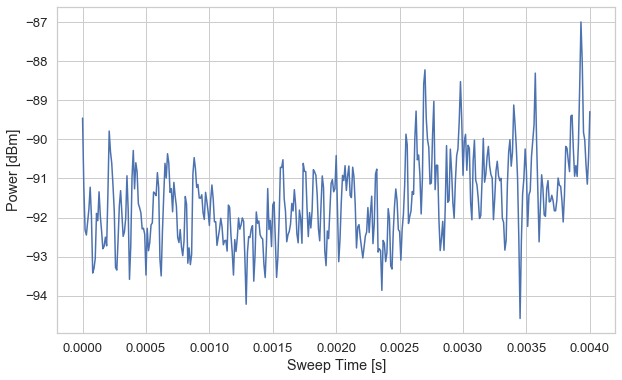

Plotting peak as a function of frequencies


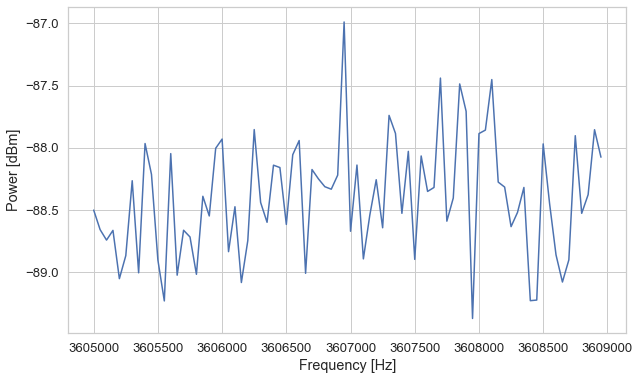

In [8]:
for numcycles in [112]:

    EXP_NAME = f'test_magic_NCycles_{numcycles}'
    sig.write(f'C2:BSWV DLY, 150e-6')
    sig.write(f'C1:BTWV TIME, {numcycles}')
    parameters = {
        'fstart': 3605000,
        'fend': 3609000,
        'fdelta': 50,
        'dutyCycleTime': 0.5,
        'epsTime': 1e-7,
        'numAvrg': 30,
        'fcenterDisplay': 3610000,
        'fspanDisplay': 0,
        'resBandwidth': 30000,
        'sweepTime': 0.004
    }
    
    print(f'running experiment for {numcycles}')
    run_time_estimate(parameters)
    _ = perform_frequency_sweep(EXP_NAME)
    sweep_data = load_data(EXP_NAME)
    visualize_sweep(sweep_data)

In [10]:
reset_avg_trace(parameters['numAvrg'])

running experiment for 151
Total wait time 0:20:00.000008
Total wait time 0:20:00.000008


Freq: 3608950 Hz, Signal: -83.110 dB, Max Signal: -81.361 dB @ Freq 3605600 Hz: 100%|██| 80/80 [20:10<00:00, 15.13s/it]


Max signal of -81.361 dBm was obtained @ 3605600 Hz
Our best trace has a peak @ 0.0 s:


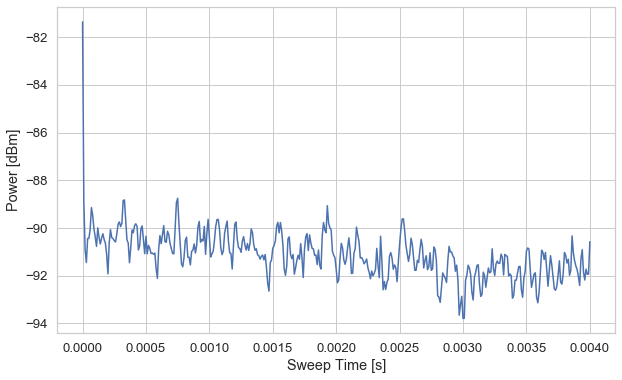

Plotting peak as a function of frequencies


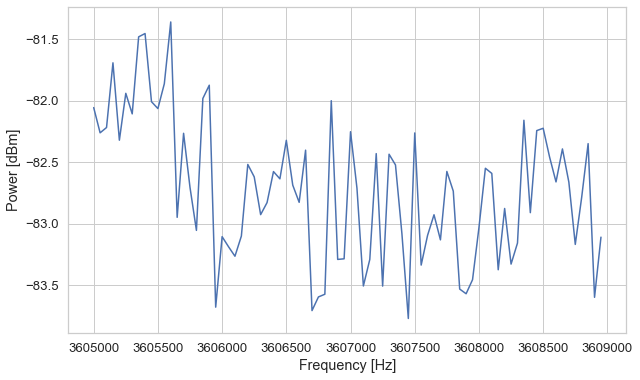

running experiment for 164
Total wait time 0:20:00.000008
Total wait time 0:20:00.000008


Freq: 3607050 Hz, Signal: -78.376 dB, Max Signal: -77.372 dB @ Freq 3605100 Hz:  52%|█ | 42/80 [10:35<09:34, 15.11s/it]

KeyboardInterrupt: 

In [11]:
for numcycles in [151, 164]:

    EXP_NAME = f'test_magic_NCycles_{numcycles}'
    sig.write(f'C2:BSWV DLY, 150e-6')
    sig.write(f'C1:BTWV TIME, {numcycles}')
    parameters = {
        'fstart': 3605000,
        'fend': 3609000,
        'fdelta': 50,
        'dutyCycleTime': 0.5,
        'epsTime': 1e-7,
        'numAvrg': 30,
        'fcenterDisplay': 3610000,
        'fspanDisplay': 0,
        'resBandwidth': 30000,
        'sweepTime': 0.004
    }
    
    print(f'running experiment for {numcycles}')
    run_time_estimate(parameters)
    _ = perform_frequency_sweep(EXP_NAME)
    sweep_data = load_data(EXP_NAME)
    visualize_sweep(sweep_data)

In [12]:
reset_avg_trace(10)

In [13]:
spec.write('SENS:AVERage OFF')

18

In [26]:
spec.query('SENS:FREQ:CENTER?')
sig.write('C1:BTWV GATE_NCYC, NCYC')

'+3.90000000000E+006\n'

In [30]:
sig = rm.open_resource('USB0::0xF4EC::0x1103::SDG1XDDD7R7784::INSTR')

19

In [53]:
sig.write('C2:BSWV DLY,50e-9')

19